## Let's create a graph

In [1]:
from raphtory import graph_loader
from raphtory import Graph
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
g = Graph()
g

Graph(number_of_edges=0, number_of_vertices=0, earliest_time=0, latest_time=0)

In [3]:
g = Graph()
g.add_vertex(1,"10")
g.vertex("10")

Vertex(name=10, properties={_id : 10})

## Adding some vertex history

In [4]:

g.add_vertex(time=1, id="ben", properties={"property 1": 1, "property 3": "hi", "property 4": True})
g.add_vertex(time=2, id="ben", properties={"property 1": 2, "property 2": 0.6, "property 4": False})
g.add_vertex(time=3, id="ben", properties={"property 2": 0.9, "property 3": "hello", "property 4": True})

g.add_vertex_properties(id="ben", properties={"static property": 123})

g.vertex("ben").property_history("property 1")

[(1, 1), (2, 2)]

## Adding some edge history

In [5]:

g.add_vertex(time=1,id="hamza")
g.add_edge(time=1, src="ben", dst="hamza", properties={"property 1": 1, "property 3": "hi", "property 4": True})
g.add_edge(time=2, src="ben", dst="hamza", properties={"property 1": 2, "property 2": 0.6, "property 4": False})
g.add_edge(time=3, src="ben", dst="hamza", properties={"property 2": 0.9, "property 3": "hello", "property 4": True})

g.add_edge_properties(src="ben", dst="hamza", properties={"static property": 123})

g.edge("ben","hamza")

Edge(source=ben, target=hamza, earliest_time=1, latest_time=3, properties={property 1 : 2, property 3 : hello, static property : 123, property 2 : 0.9, property 4 : true})

## Loading a real graph

In [6]:
reddit_graph = graph_loader.reddit_hyperlink_graph()

In [7]:
print(reddit_graph)

Graph(number_of_edges=234792, number_of_vertices=54075, earliest_time=1388506820, latest_time=1493570870)


In [8]:
print(reddit_graph.vertex("conspiracy"))

edge = reddit_graph.edge("conspiracy","documentaries")
print("property names: ",edge.property_names())
print("sentiment history: ",edge.property_history("compound_sentiment"))

edge_perspective = reddit_graph.at(1414676601).edge("conspiracy","documentaries")
print("sentiment history: ",edge_perspective["compound_sentiment"])

reddit_graph.vertex("conspiracy").out_neighbours().out_neighbours().out_neighbours()

Vertex(name=conspiracy, properties={_id : conspiracy})
property names:  ['post_label', 'post_id', 'word_count', 'long_words', 'sentences', 'readability', 'positive_sentiment', 'negative_sentiment', 'compound_sentiment']
sentiment history:  [(1404952792, 0.2732), (1414676601, 0.2344), (1418639874, 0.0), (1420030124, -0.2481), (1426362695, 0.0), (1427198700, -0.2023), (1427894452, 0.0), (1429187302, 0.5562), (1429644527, 0.296), (1431911341, -0.3595), (1433653011, -0.34), (1435258425, 0.0772), (1439068701, -0.5574), (1439249314, 0.0), (1440456620, 0.4019), (1446586617, 0.0), (1447125847, -0.7042), (1447422296, 0.0387), (1450563607, 0.8192), (1450658697, 0.6841), (1450863723, 0.2732), (1451249771, -0.4767), (1455119795, 0.0), (1455295188, -0.4939), (1456505801, -0.6908), (1456949833, 0.0), (1458061181, 0.3384), (1460498612, -0.5267), (1461879765, -0.6136), (1463741129, 0.0), (1466862772, -0.1779), (1471350739, -0.6808), (1479538764, 0.0), (1480262620, 0.25), (1482314435, 0.6908), (1483690

PathFromVertex(Vertex(name=cancer, properties={_id : cancer}), Vertex(name=soccer, properties={_id : soccer}), Vertex(name=pics, properties={_id : pics}), Vertex(name=funny, properties={_id : funny}), Vertex(name=bitcoin, properties={_id : bitcoin}), Vertex(name=propaganda, properties={_id : propaganda}), Vertex(name=conspiracy, properties={_id : conspiracy}), Vertex(name=askreddit, properties={_id : askreddit}), Vertex(name=trees, properties={_id : trees}), Vertex(name=cricket, properties={_id : cricket}), ...)

## Let's have a look at the daily traffic

<Axes: xlabel='Time', ylabel='Interactions'>

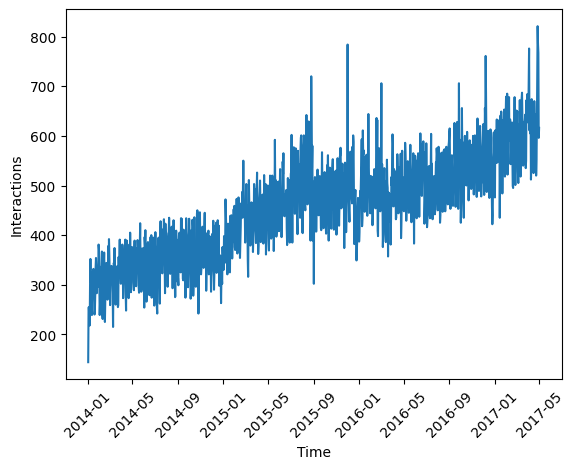

In [9]:
views = reddit_graph.rolling(window=86400) 

timestamps   = []
edge_count   = []

for view in views:
    time = datetime.datetime.fromtimestamp(view.latest_time())
    timestamps.append(time)
    edge_count.append(view.num_edges())            

sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Interactions")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

## Average Weekly sentiment for a given subreddit

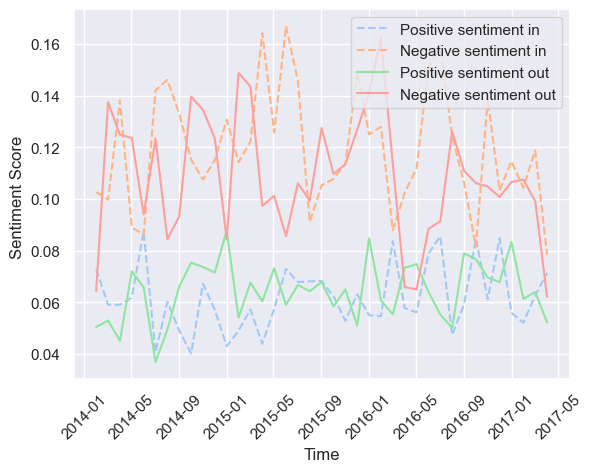

In [10]:
views = reddit_graph.rolling(2629743) 

timestamps             = []
positive_sentiment_in  = []
positive_sentiment_out = []
negative_sentiment_in  = []
negative_sentiment_out = []
def edge_weight(edge,prop_name):
    return sum(list(map(lambda e: e[1],edge.property_history(prop_name)))), len(edge.property_history(prop_name))

def weighted_average_degree(vertex,prop_name,incoming):
    edges = list(vertex.in_edges() if incoming else vertex.out_edges())
    return sum(list(map(lambda e: edge_weight(e,prop_name)[0],edges)))/max(1,sum(list(map(lambda e: edge_weight(e,prop_name)[1],edges))))

for view in views:
    vertex = view.vertex("conspiracy")
    if(vertex is not None):
        timestamps.append(datetime.datetime.fromtimestamp(view.latest_time()))
        positive_sentiment_in.append(weighted_average_degree(vertex,"positive_sentiment",incoming=True))
        positive_sentiment_out.append(weighted_average_degree(vertex,"positive_sentiment",incoming=False))
        negative_sentiment_in.append(weighted_average_degree(vertex,"negative_sentiment",incoming=True))
        negative_sentiment_out.append(weighted_average_degree(vertex,"negative_sentiment",incoming=False))        

sns.set()
sns.set_palette("pastel")
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Sentiment Score ")

sns.lineplot(x = timestamps, y = positive_sentiment_in,ax=ax,label="Positive sentiment in",linestyle="--")
sns.lineplot(x = timestamps, y = negative_sentiment_in,ax=ax,label ="Negative sentiment in",linestyle="--")
sns.lineplot(x = timestamps, y = positive_sentiment_out,ax=ax,label="Positive sentiment out")
sns.lineplot(x = timestamps, y = negative_sentiment_out,ax=ax,label ="Negative sentiment out")
ax.legend(loc="best")

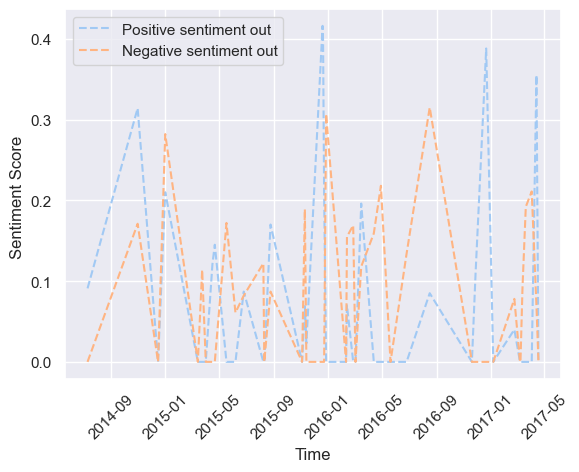

In [11]:
pos  = [x[1] for x in reddit_graph.edge("conspiracy","documentaries").property_history("positive_sentiment")]
neg  = [x[1] for x in reddit_graph.edge("conspiracy","documentaries").property_history("negative_sentiment")]
time = [x[0] for x in reddit_graph.edge("conspiracy","documentaries").property_history("positive_sentiment")]
timestamps = list(map(lambda t: datetime.datetime.fromtimestamp(t),time))
sns.set()
sns.set_palette("pastel")
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Sentiment Score ")
sns.lineplot(x = timestamps, y = pos,ax=ax,label="Positive sentiment out",linestyle="--")
sns.lineplot(x = timestamps, y = neg,ax=ax,label ="Negative sentiment out",linestyle="--")
ax.legend(loc="best")